In [2]:
from warnings import simplefilter
simplefilter('ignore')

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
df = pd.read_csv('./TimeSeriesData/DailyDelhiClimateTrain.csv', index_col='date', parse_dates=True)

In [4]:
df.head()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000


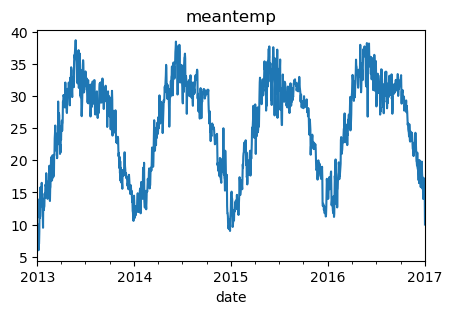

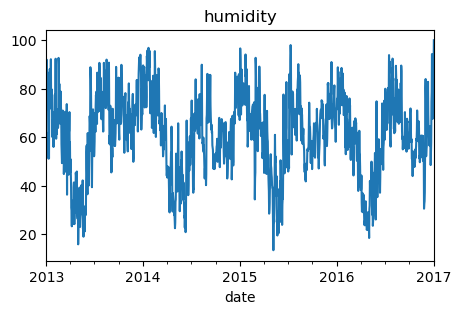

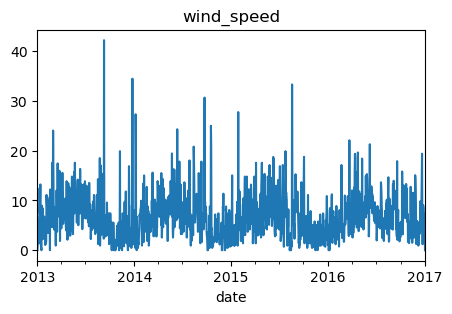

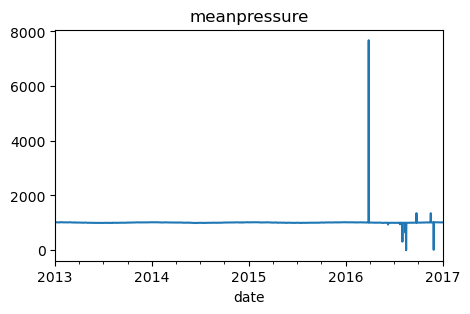

In [5]:
for column in df:
    plt.figure(figsize=(5, 3)) # Creates a new figure
    df[column].plot(kind='line') # Plots the column
    plt.title(column) # Sets the title of the plot as the column name
    plt.show() # Displays the plot

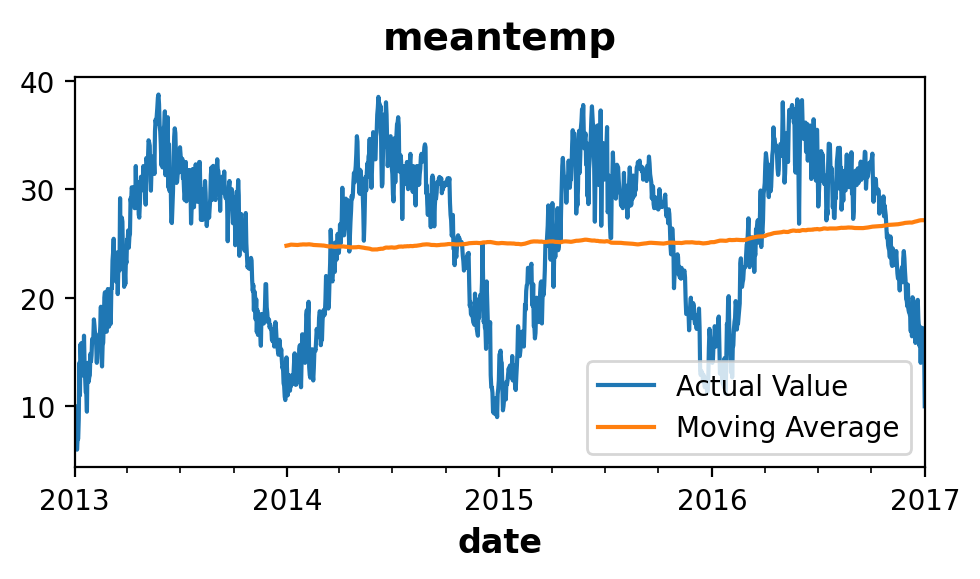

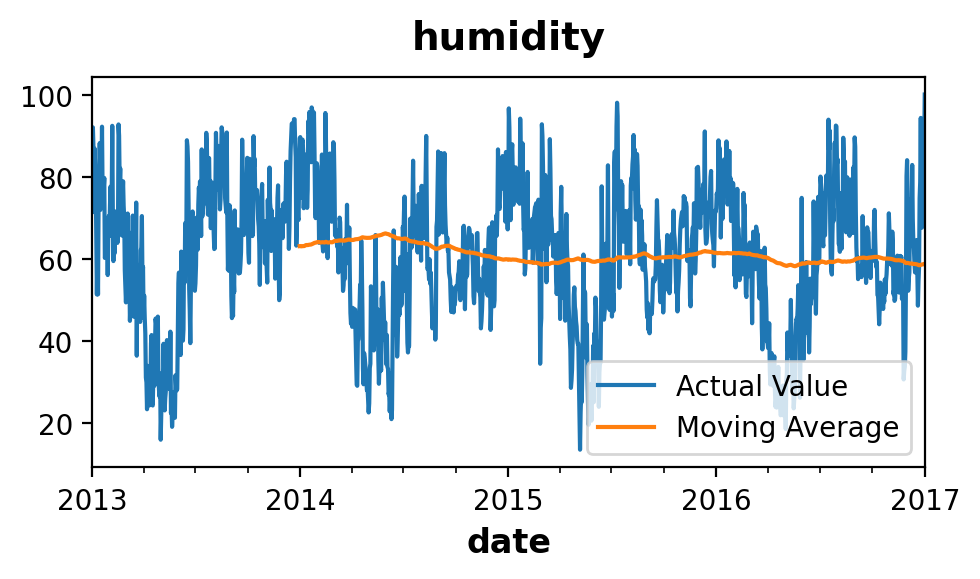

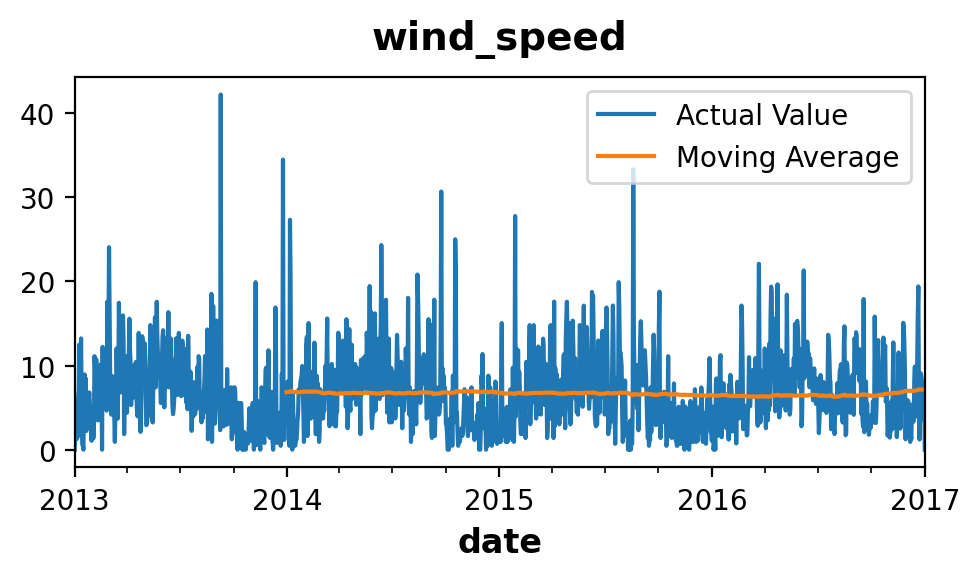

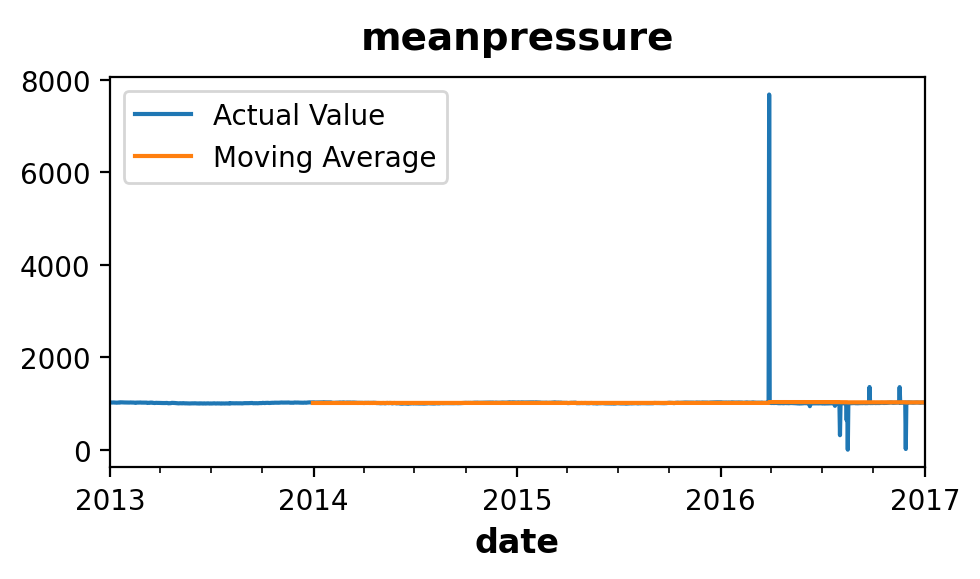

In [38]:
for column in df:
    plt.figure(figsize=(5, 3))  # Creates a new figure
    df[column].plot(kind='line')  # Plots the actual values
    df[column].rolling(window=365).mean().plot(kind='line')  # Plots the moving average
    plt.title(column)  # Sets the title of the plot as the column name
    plt.legend(['Actual Value', 'Moving Average'])  # Adds a legend
    plt.show() 

In [39]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from xgboost import XGBRegressor


In [40]:
y = df.copy()

In [41]:
df.shape

(1462, 4)

In [44]:
# plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)

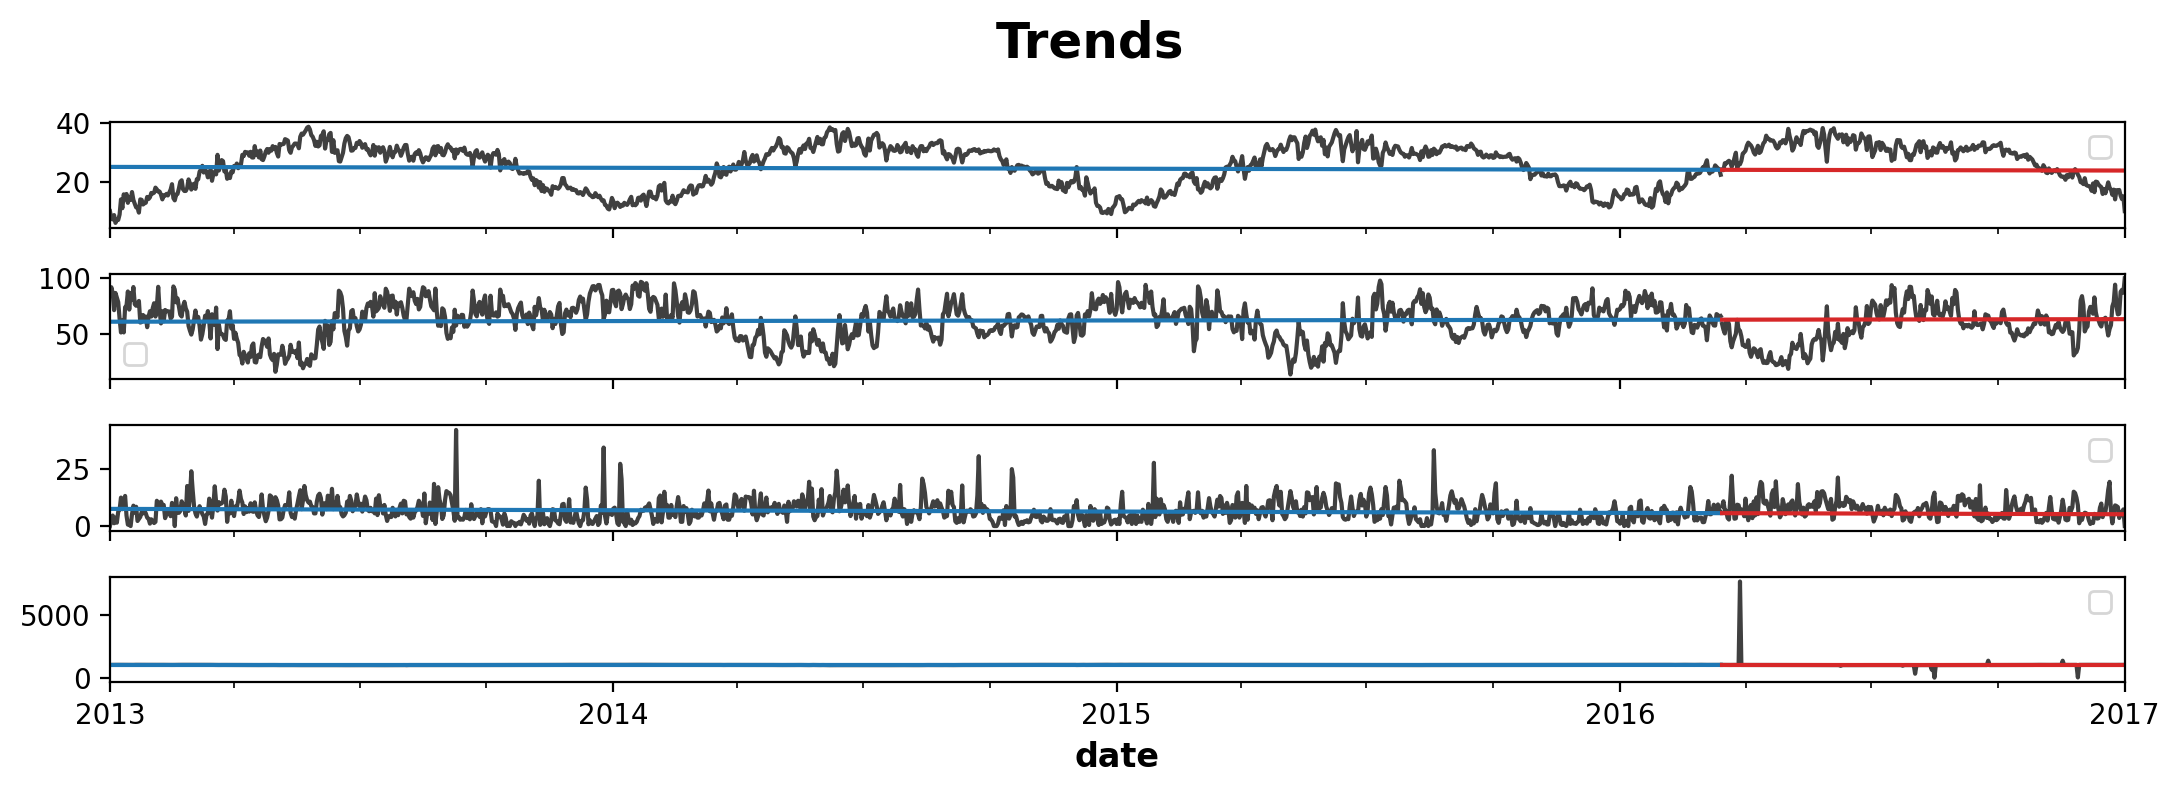

In [45]:
dp = DeterministicProcess(
    index=y.index,  # dates from the training data
    constant=True,  # the intercept
    order=1,        # linear trend
    drop=True,      # drop terms to avoid collinearity
)
X = dp.in_sample()  # features for the training data

idx_train, idx_test = train_test_split(
    y.index, test_size=0.2, shuffle=False,
)
X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

# Fit trend model
model = LinearRegression(fit_intercept=False)
model.fit(X_train, y_train)

# Make predictions
y_fit = pd.DataFrame(
    model.predict(X_train),
    index=y_train.index,
    columns=y_train.columns,
)
y_pred = pd.DataFrame(
    model.predict(X_test),
    index=y_test.index,
    columns=y_test.columns,
)

# Plot
axs = y_train.plot(color='0.25', subplots=True, sharex=True)
axs = y_test.plot(color='0.25', subplots=True, sharex=True, ax=axs)
axs = y_fit.plot(color='C0', subplots=True, sharex=True, ax=axs)
axs = y_pred.plot(color='C3', subplots=True, sharex=True, ax=axs)
for ax in axs: ax.legend([])
_ = plt.suptitle("Trends")

In [46]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax

def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax



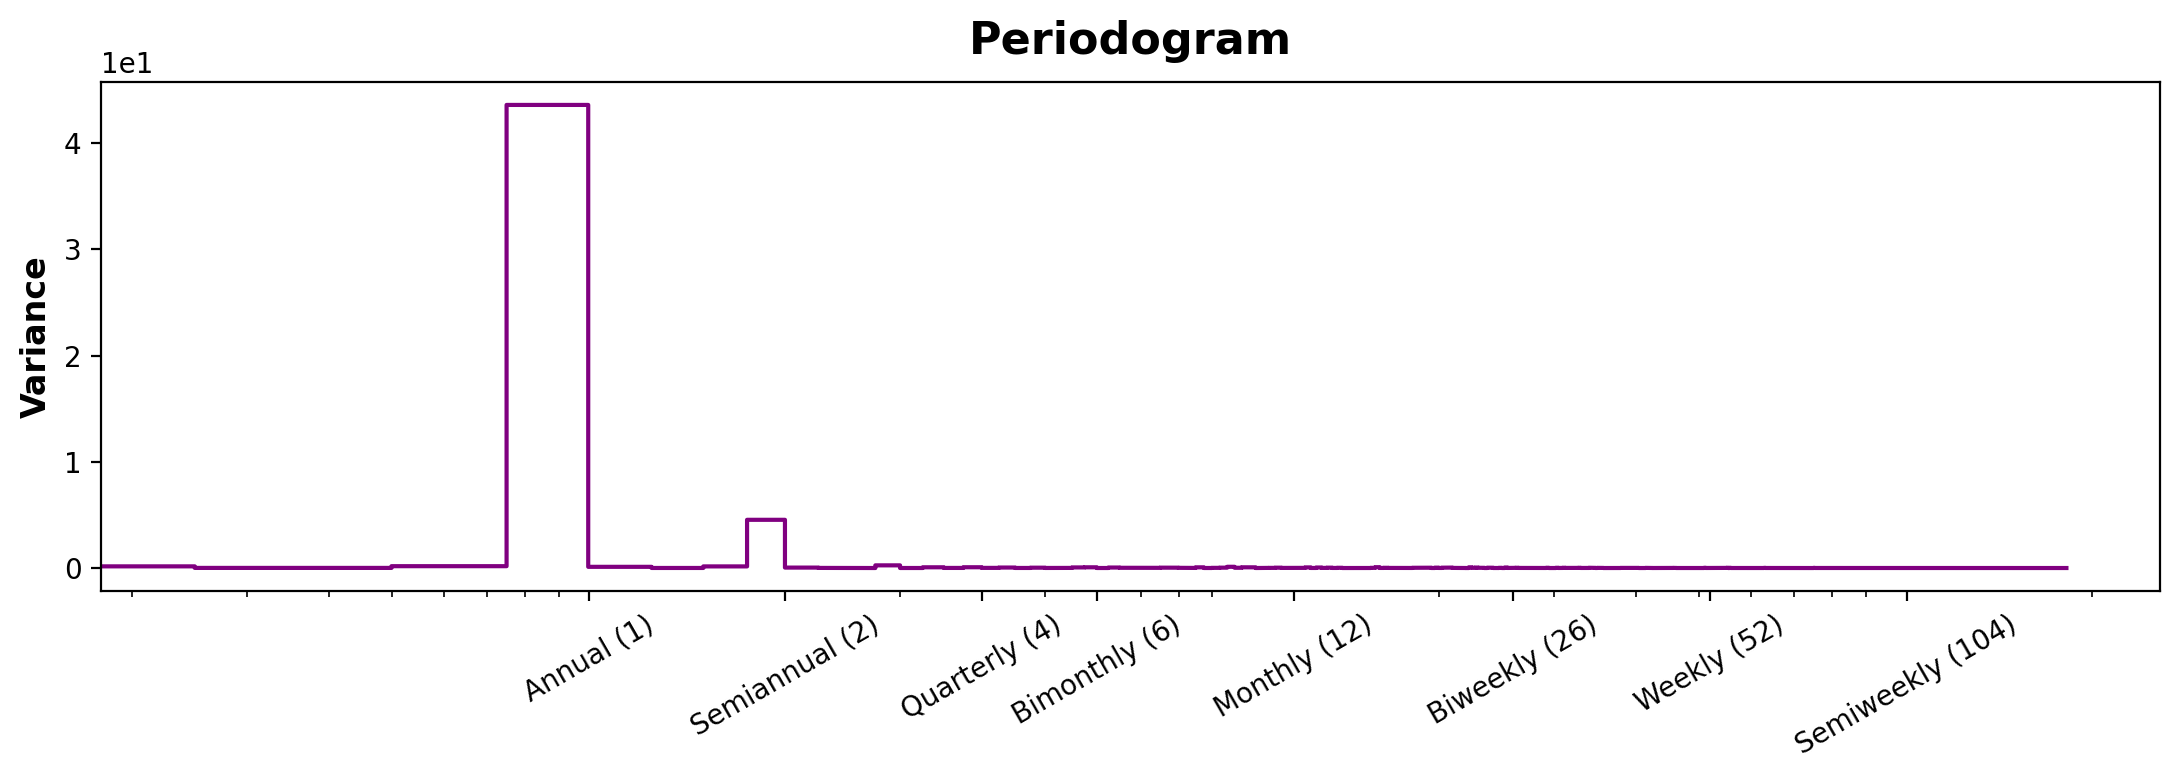

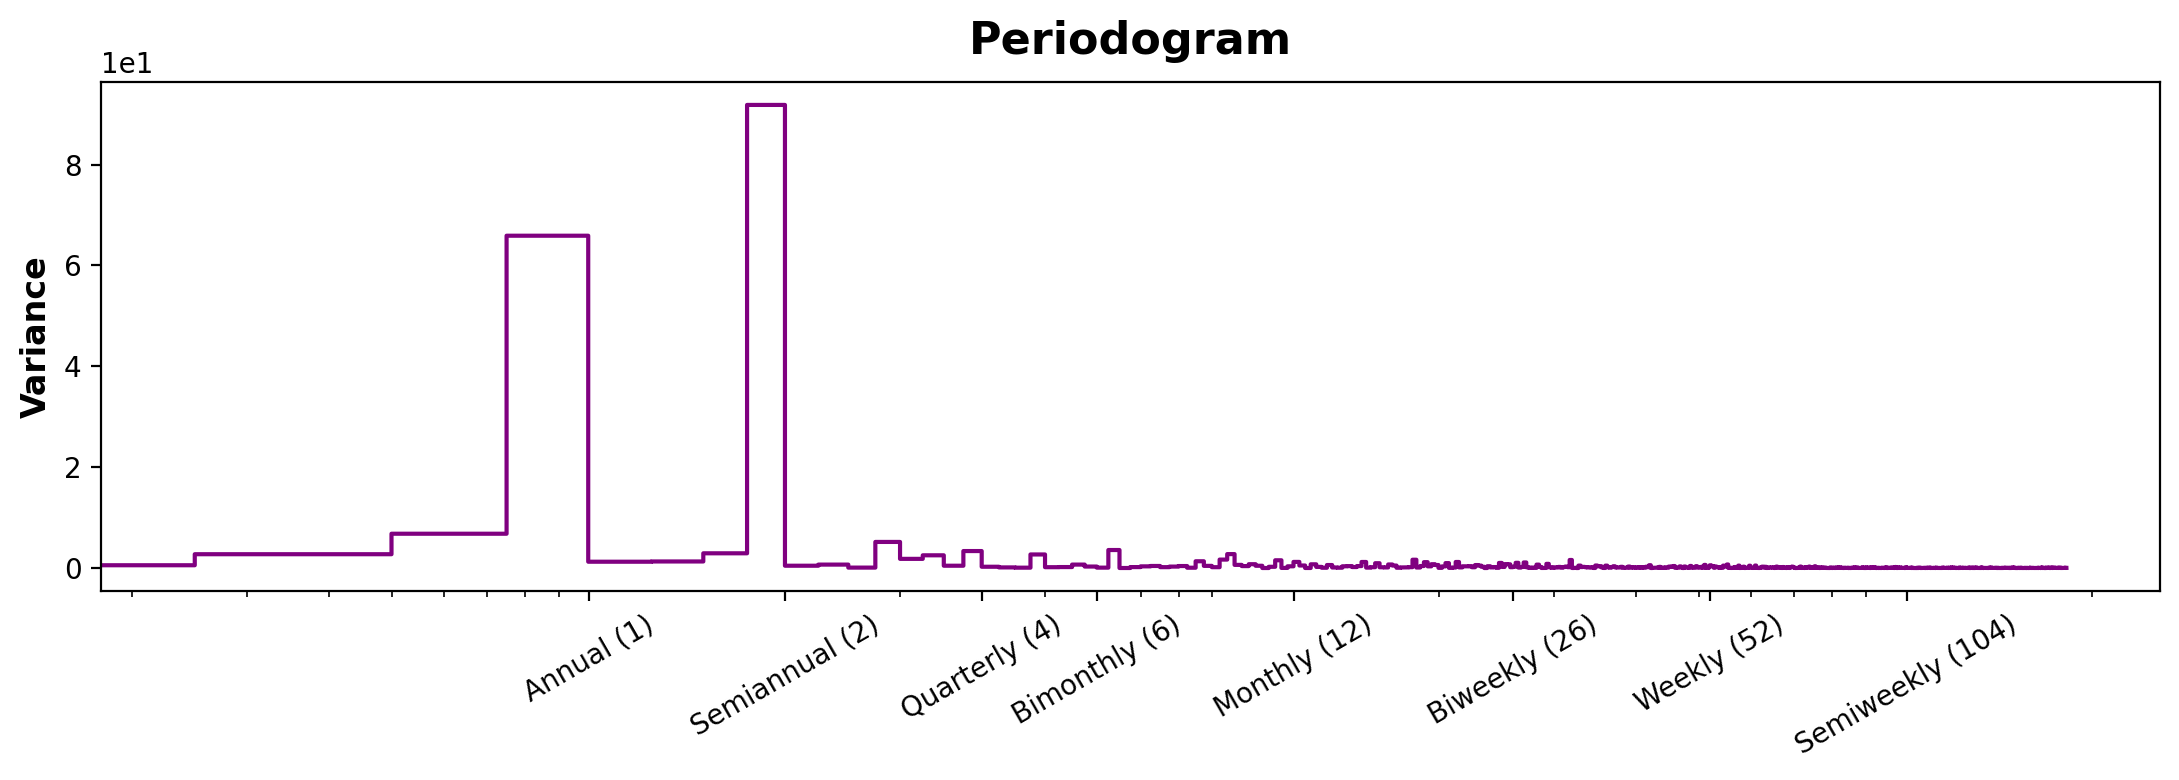

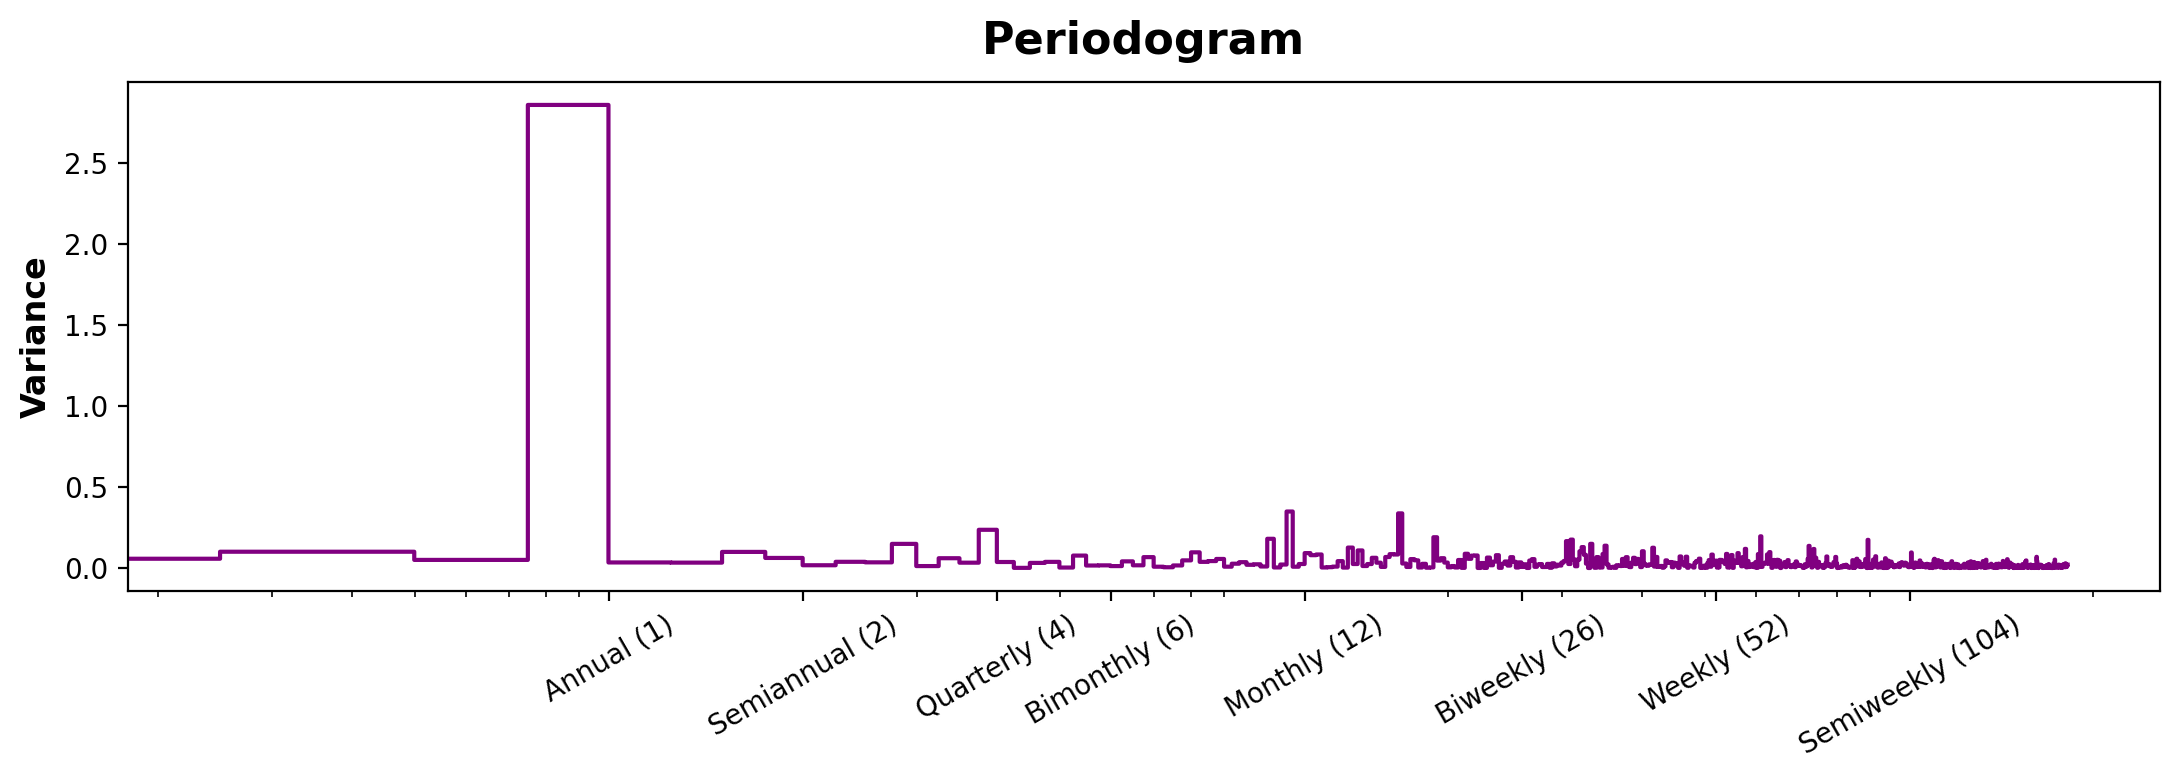

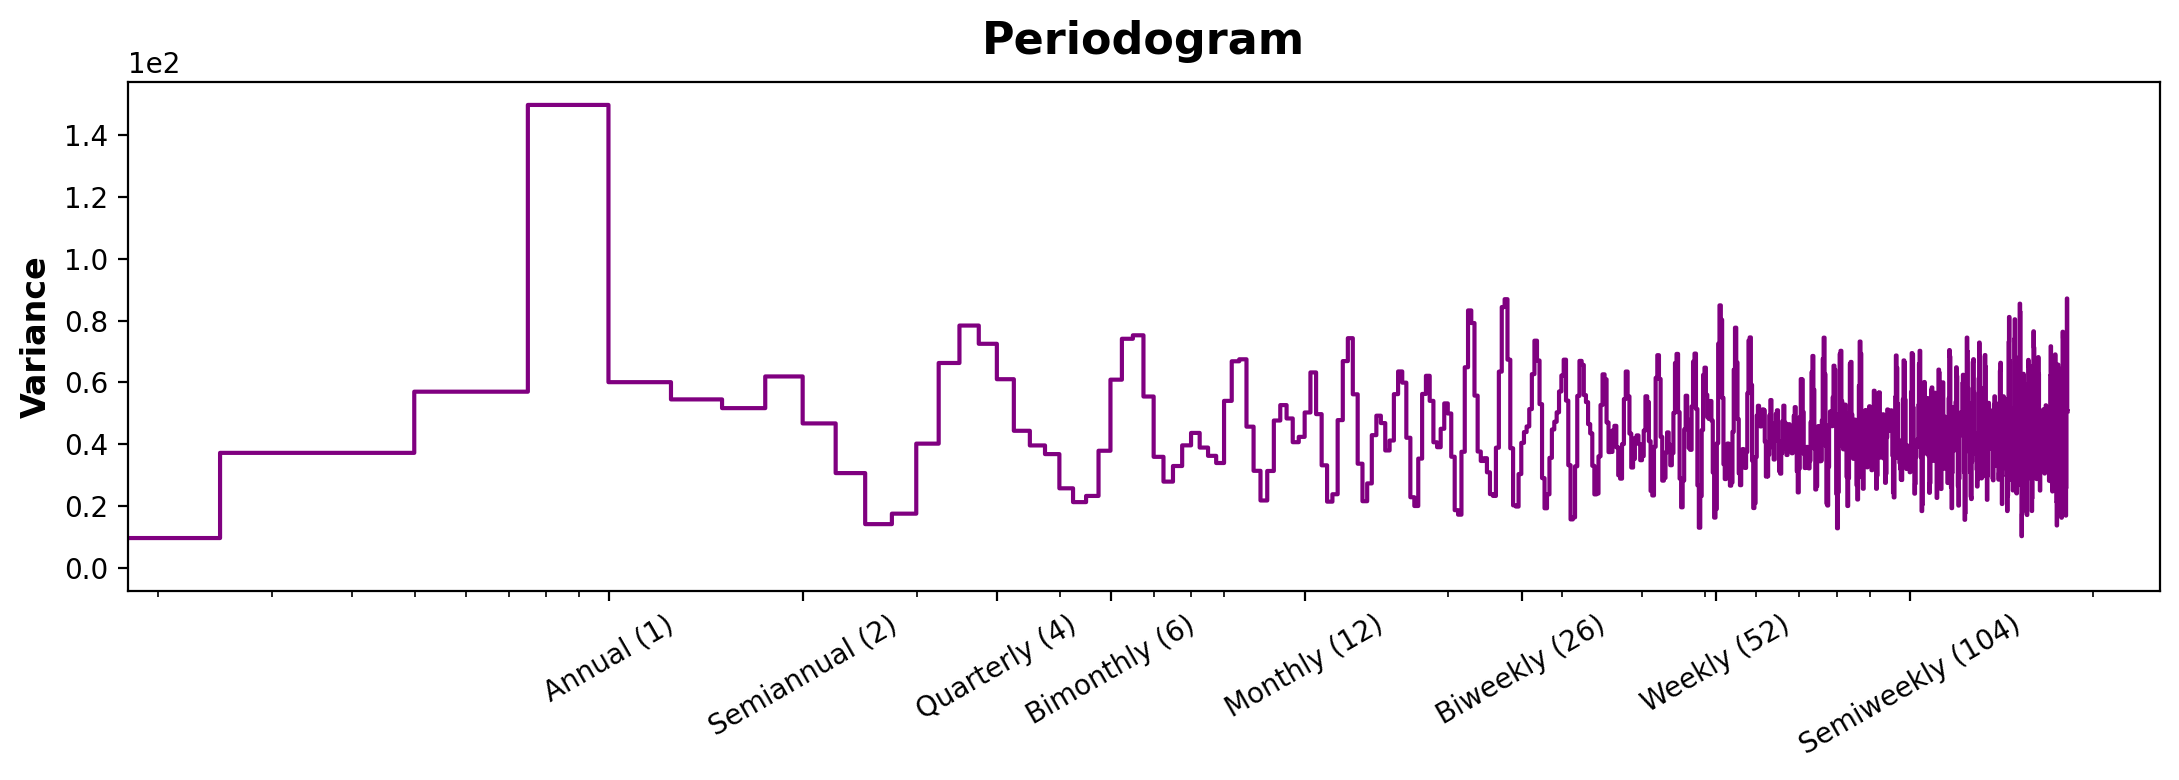

In [50]:
for col in df.columns:
    plot_periodogram(y[col])

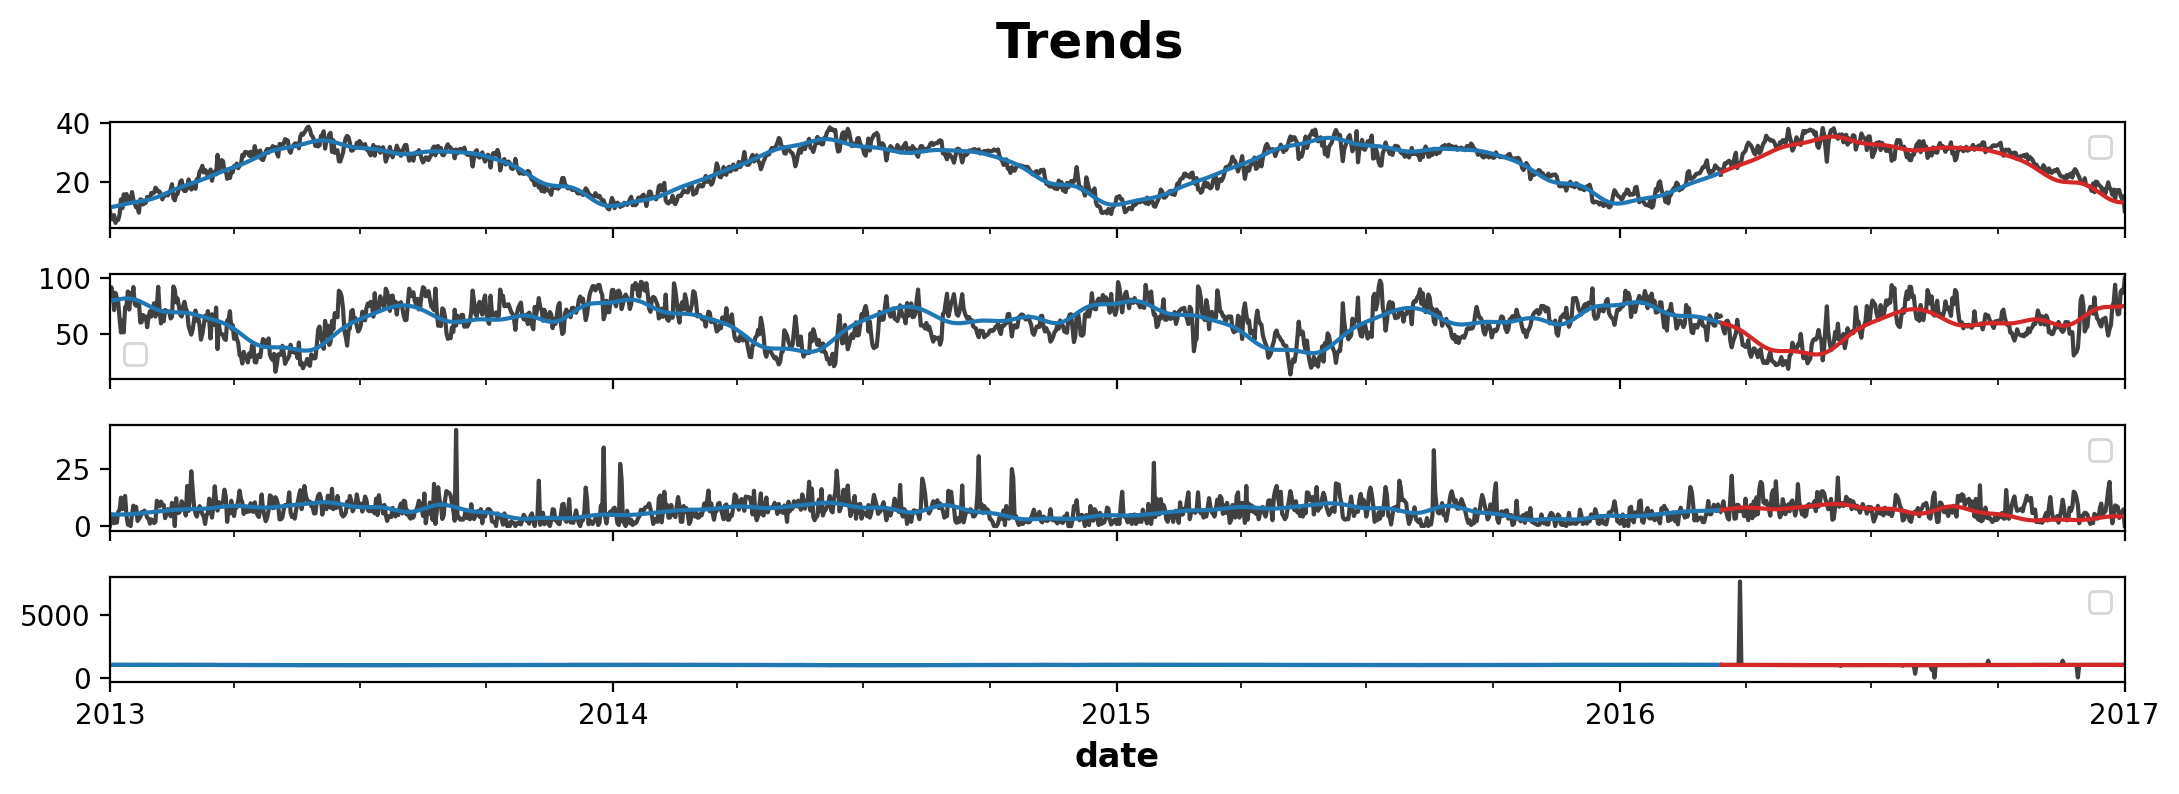

In [51]:
fourier = CalendarFourier(freq='Y', order=10)
dp = DeterministicProcess(
    index=y.index,  # dates from the training data
    constant=True,  # the intercept
    additional_terms=[fourier],
    order=1,        # linear trend
    drop=True,      # drop terms to avoid collinearity
)
X = dp.in_sample()  # features for the training data

idx_train, idx_test = train_test_split(
    y.index, test_size=0.2, shuffle=False,
)
X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

# Fit trend model
model = LinearRegression(fit_intercept=False)
model.fit(X_train, y_train)

# Make predictions
y_fit = pd.DataFrame(
    model.predict(X_train),
    index=y_train.index,
    columns=y_train.columns,
)
y_pred = pd.DataFrame(
    model.predict(X_test),
    index=y_test.index,
    columns=y_test.columns,
)

# Plot
axs = y_train.plot(color='0.25', subplots=True, sharex=True)
axs = y_test.plot(color='0.25', subplots=True, sharex=True, ax=axs)
axs = y_fit.plot(color='C0', subplots=True, sharex=True, ax=axs)
axs = y_pred.plot(color='C3', subplots=True, sharex=True, ax=axs)
for ax in axs: ax.legend([])
_ = plt.suptitle("Trends")

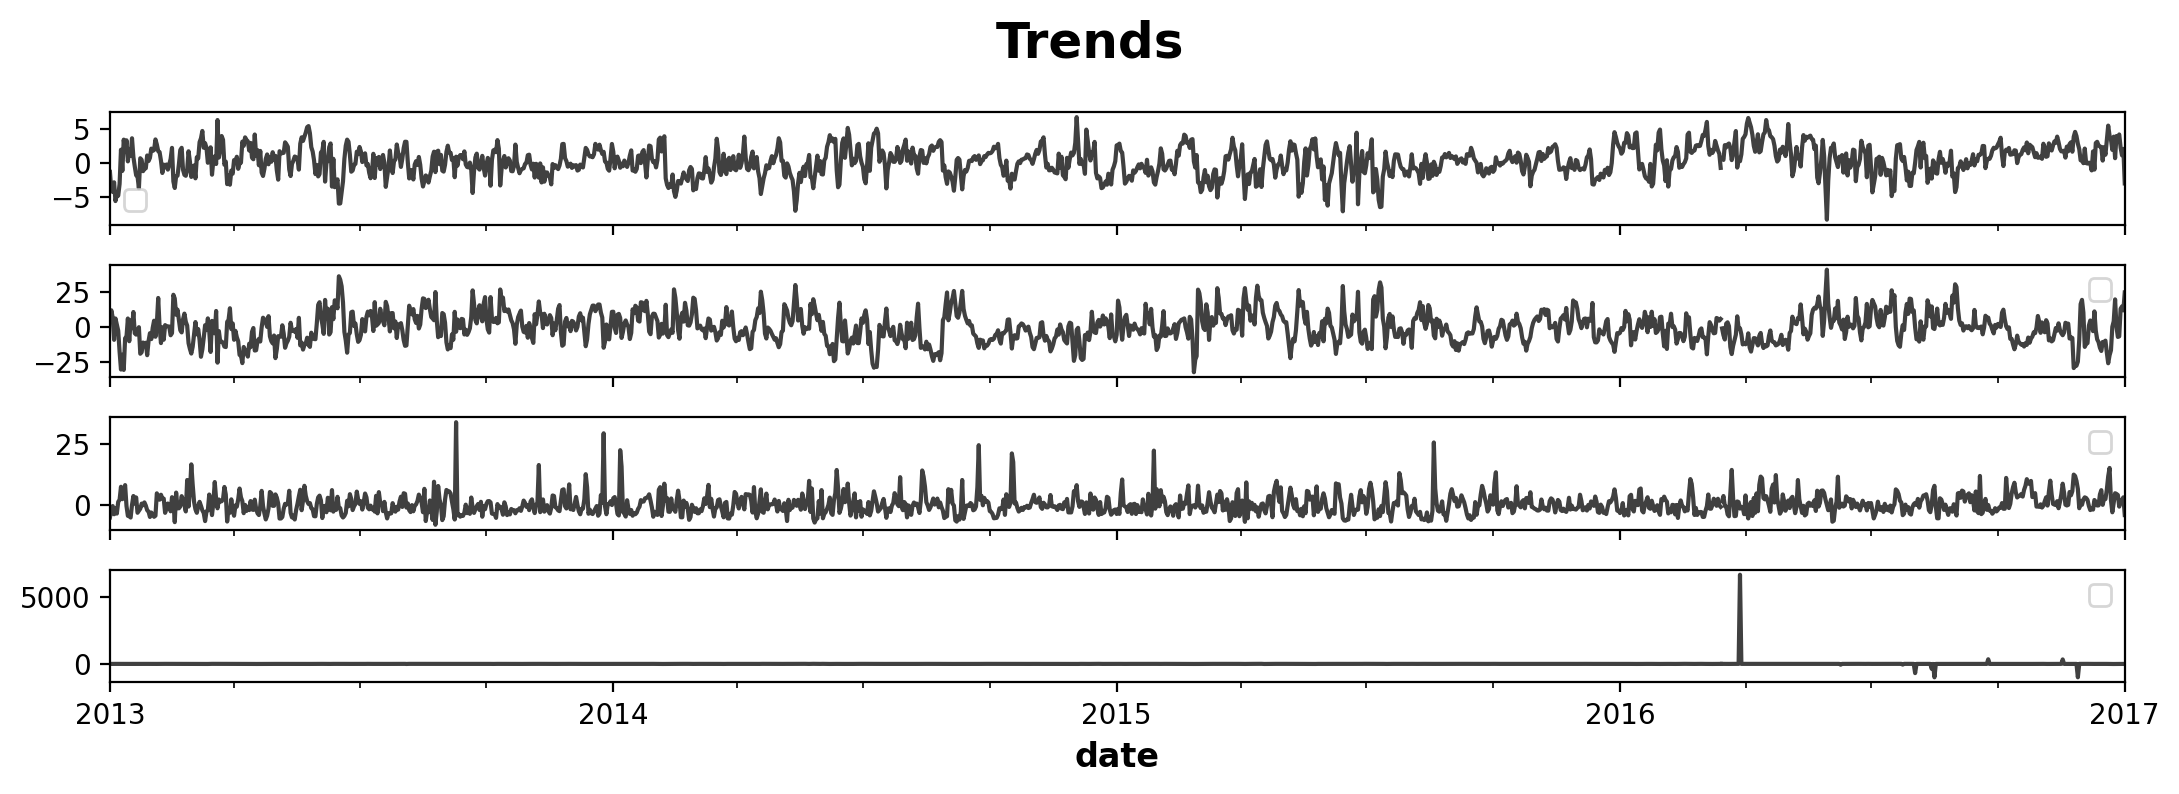

In [56]:

y_res_train = y_train - y_fit
y_res_test = y_test - y_pred
axs = y_res_train.plot(color='0.25', subplots=True, sharex=True)
axs = y_res_test.plot(color='0.25', subplots=True, sharex=True, ax=axs)
for ax in axs: ax.legend([])
_ = plt.suptitle("Trends")

In [52]:


from scipy.signal import periodogram
from statsmodels.graphics.tsaplots import plot_pacf


def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax


def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig


In [58]:
X_train

,const,trend,"sin(1,freq=A-DEC)","cos(1,freq=A-DEC)","sin(2,freq=A-DEC)","cos(2,freq=A-DEC)","sin(3,freq=A-DEC)","cos(3,freq=A-DEC)","sin(4,freq=A-DEC)","cos(4,freq=A-DEC)",...,"sin(6,freq=A-DEC)","cos(6,freq=A-DEC)","sin(7,freq=A-DEC)","cos(7,freq=A-DEC)","sin(8,freq=A-DEC)","cos(8,freq=A-DEC)","sin(9,freq=A-DEC)","cos(9,freq=A-DEC)","sin(10,freq=A-DEC)","cos(10,freq=A-DEC)"
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1.0,1.0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
2013-01-02,1.0,2.0,0.017213,0.999852,0.034422,0.999407,0.051620,0.998667,0.068802,0.997630,...,0.103102,0.994671,0.120208,0.992749,0.137279,0.990532,0.154309,0.988023,0.171293,0.985220
2013-01-03,1.0,3.0,0.034422,0.999407,0.068802,0.997630,0.103102,0.994671,0.137279,0.990532,...,0.205104,0.978740,0.238673,0.971100,0.271958,0.962309,0.304921,0.952378,0.337523,0.941317
2013-01-04,1.0,4.0,0.051620,0.998667,0.103102,0.994671,0.154309,0.988023,0.205104,0.978740,...,0.304921,0.952378,0.353676,0.935368,0.401488,0.915864,0.448229,0.893919,0.493776,0.869589
2013-01-05,1.0,5.0,0.068802,0.997630,0.137279,0.990532,0.205104,0.978740,0.271958,0.962309,...,0.401488,0.915864,0.463550,0.886071,0.523416,0.852078,0.580800,0.814046,0.635432,0.772157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-03-10,1.0,1165.0,0.926324,0.376728,0.697944,-0.716152,-0.400454,-0.916317,-0.999668,0.025748,...,0.733885,0.679273,0.905702,-0.423914,-0.051479,-0.998674,-0.944489,-0.328542,-0.660152,0.751132
2016-03-11,1.0,1166.0,0.932655,0.360771,0.672949,-0.739689,-0.447094,-0.894487,-0.995546,0.094279,...,0.799839,0.600214,0.848351,-0.529434,-0.187719,-0.982223,-0.983798,-0.179281,-0.522133,0.852864
2016-03-12,1.0,1167.0,0.938710,0.344707,0.647161,-0.762354,-0.492548,-0.870285,-0.986731,0.162366,...,0.857315,0.514793,0.778764,-0.627317,-0.320423,-0.947274,-0.999668,-0.025748,-0.368763,0.929523


In [71]:
y_fit.index.names = ['date', 'factors']
y_pred.index.names = ['date', 'factors']

In [75]:
y_train, y_fit

(             meantemp   humidity  wind_speed  meanpressure
 date                                                      
 2013-01-01  10.000000  84.500000    0.000000   1015.666667
 2013-01-02   7.400000  92.000000    2.980000   1017.800000
 2013-01-03   7.166667  87.000000    4.633333   1018.666667
 2013-01-04   8.666667  71.333333    1.233333   1017.166667
 2013-01-05   6.000000  86.833333    3.700000   1016.500000
 ...               ...        ...         ...           ...
 2016-03-10  25.562500  57.437500    7.981250   1013.187500
 2016-03-11  25.066667  67.800000    6.546667   1012.533333
 2016-03-12  24.562500  66.937500    9.487500   1009.562500
 2016-03-13  24.250000  65.187500    6.843750   1011.187500
 2016-03-14  22.375000  66.000000    6.275000   1014.312500
 
 [1169 rows x 4 columns],
 date        factors     
 2013-01-01  meantemp          11.341963
             humidity          79.686739
             wind_speed         5.162147
             meanpressure    1017.790106
 2

In [82]:
y_fit = y_fit.unstack()
y_pred = y_pred.unstack()

In [83]:
y_train, y_fit

(             meantemp   humidity  wind_speed  meanpressure
 date                                                      
 2013-01-01  10.000000  84.500000    0.000000   1015.666667
 2013-01-02   7.400000  92.000000    2.980000   1017.800000
 2013-01-03   7.166667  87.000000    4.633333   1018.666667
 2013-01-04   8.666667  71.333333    1.233333   1017.166667
 2013-01-05   6.000000  86.833333    3.700000   1016.500000
 ...               ...        ...         ...           ...
 2016-03-10  25.562500  57.437500    7.981250   1013.187500
 2016-03-11  25.066667  67.800000    6.546667   1012.533333
 2016-03-12  24.562500  66.937500    9.487500   1009.562500
 2016-03-13  24.250000  65.187500    6.843750   1011.187500
 2016-03-14  22.375000  66.000000    6.275000   1014.312500
 
 [1169 rows x 4 columns],
 factors      meantemp   humidity  wind_speed  meanpressure
 date                                                      
 2013-01-01  11.341963  79.686739    5.162147   1017.790106
 2013-01-02 

In [87]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_train.meantemp, y_fit.meantemp, squared=False), mean_squared_error(y_test, y_pred, squared=False)

(2.0720965662140527, 104.89137902699312)

In [88]:
for col in y.columns:
    print(mean_squared_error(y_train[col], y_fit[col], squared=False), mean_squared_error(y_test[col], y_pred[col], squared=False))

2.0720965662140527 2.416018266395997
10.481356259698101 10.94885162771986
4.189316052925109 4.202886910542366
2.241474903128122 401.9977593033143


In [89]:
class BoostedHybrid:
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        self.y_columns = None  # store column names from fit method

    def fit(self, X_1, X_2, y):
        # YOUR CODE HERE: fit self.model_1
        self.model_1.fit(X_1, y)

        y_fit = pd.DataFrame(
            # YOUR CODE HERE: make predictions with self.model_1
            self.model_1.predict(X_1),
            index=X_1.index, columns=y.columns,
        )

        # YOUR CODE HERE: compute residuals
        y_resid = y - y_fit
        y_resid = y_resid.stack().squeeze() # wide to long

        # YOUR CODE HERE: fit self.model_2 on residuals
        self.model_2.fit(X_2, y_resid)

        # Save column names for predict method
        self.y_columns = y.columns
        # Save data for question checking
        self.y_fit = y_fit
        self.y_resid = y_resid

    def predict(self, X_1, X_2):
        y_pred = pd.DataFrame(
            # YOUR CODE HERE: predict with self.model_1
            self.model_1.predict(X_1),
            index=X_1.index, columns=self.y_columns,
        )
        y_pred = y_pred.stack().squeeze()  # wide to long

        # YOUR CODE HERE: add self.model_2 predictions to y_pred
        y_pred += self.model_2.predict(X_2)
        
        return y_pred.unstack()  # long to wide


In [91]:
fourier = CalendarFourier(freq='Y', order=10)
dp = DeterministicProcess(
    index=y.index, 
    constant=True, 
    additional_terms=[fourier],
    order=1, 
    drop=True)
X_1 = dp.in_sample()

In [93]:
X_2 = y.stack()

In [94]:
X_2

date                    
2013-01-01  meantemp          10.000000
            humidity          84.500000
            wind_speed         0.000000
            meanpressure    1015.666667
2013-01-02  meantemp           7.400000
                               ...     
2016-12-31  meanpressure    1016.100000
2017-01-01  meantemp          10.000000
            humidity         100.000000
            wind_speed         0.000000
            meanpressure    1016.000000
Length: 5848, dtype: float64